In [58]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
# need to 'pip install vega' before using renderer
alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD

import os
from joblib import dump, load

# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
%matplotlib inline
#fix random seed
np.random.seed(1)

In [43]:
!jupyter nbextension enable vega --py --sys-prefix

Enabling notebook extension jupyter-vega/index...
      - Validating: OK


In [44]:
TRAINING_FILE = "training.csv"
TEST_FILE = "test.csv"
df = pd.read_csv(TRAINING_FILE)
print(df.isnull().sum())
df.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS
1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS
2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS
3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS
4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT


The code below is old version, which executes the **train_test_split()**

In [45]:
# #new_df = df[df.topic!='IRRELEVANT'] # We remove rows that are "IRRELEVANT"
# new_df = df
# data_x = new_df.article_words
# data_y = new_df.topic
# train_x,dev_x,train_y,dev_y = train_test_split(data_x,data_y,test_size = 0.1,shuffle=False)
# le = preprocessing.LabelEncoder()
# le.fit(train_y)
# encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
# en_train_y = le.transform(train_y)
# en_dev_y = le.transform(dev_y)
# topics = list(set(df['topic']))

The code below is new version, which does not execute the **train_test_split()**

In [46]:
new_df = df
train_x = new_df.article_words.apply(lambda x: x.replace('_', ''))
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
en_train_y = le.transform(train_y)
topics = list(set(df['topic']))
TOPIC_COUNT = len(topics)

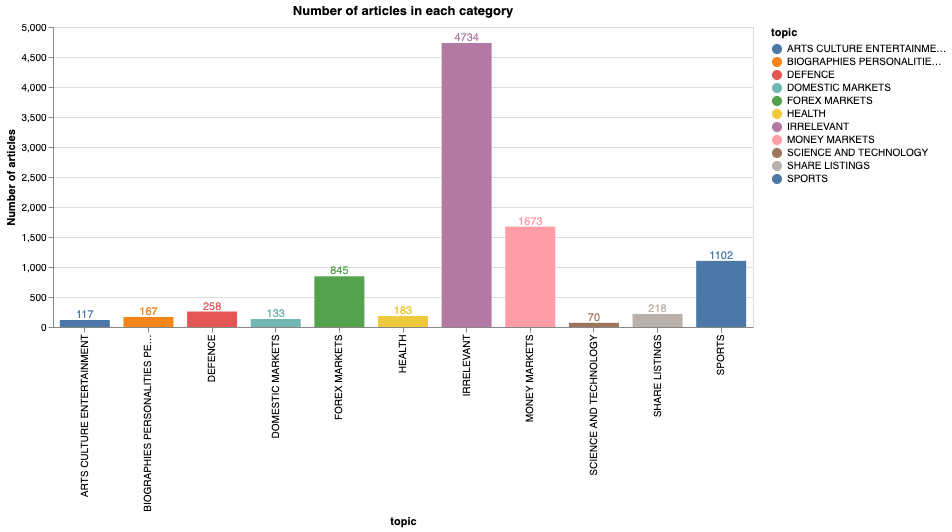

In [47]:
alt.data_transformers.disable_max_rows()
bars = alt.Chart(train_y.to_frame()).mark_bar(size=50).encode(
x=alt.X("topic"),
y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
tooltip=[alt.Tooltip('count()', title='Number of articles'), 'topic'],
color='topic'

)

text = bars.mark_text(
align='center',
baseline='bottom',
).encode(
text='count()'
)

(bars + text).properties(
    height=300, 
    width=700,
    title = "Number of articles in each category",
)




### Transform Training Text to TF-IDF 

The code below is old version, which executes the **train_test_split()**

In [48]:
# vectorizer = TfidfVectorizer()
# train_vectors = vectorizer.fit_transform(train_x)
# dev_vectors = vectorizer.transform(dev_x)
# print(train_vectors.shape,dev_vectors.shape)
# print(train_vectors.nnz/float(train_vectors.shape[0]))

The code below is new version without **train_test_split()**

### SMOTE Is Applied Here Now!

#### Finding the Best **n-component** in TruncatedSVD

In [49]:
smote = SMOTE(random_state=1)
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(train_x)
train_vectors = vectorizer.transform(train_x)
smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
train_sparse = csr_matrix(smo_x)
print(train_sparse.shape)

(52074, 9495)


In [53]:
%%time
tsvd = TruncatedSVD(n_components=train_sparse.shape[1]-1)
train_tsvd = tsvd.fit(smo_x)
tsvd_var_ratios = tsvd.explained_variance_ratio_

CPU times: user 47min 6s, sys: 10min 16s, total: 57min 23s
Wall time: 52min 34s


In [54]:
def select_n_components(var_ratio,goal_var:float)-> int:
    total_variance = 0.0
    n_components=0
    for explained_variance in var_ratio:
        total_variance +=explained_variance
        n_components+=1
        if (total_variance>=goal_var):
            break
    return (n_components)
best_n_components = select_n_components(tsvd_var_ratios,0.95)
print("The best n_component number is",best_n_components)

The best n_component number is 2261


In [55]:
tsvd = TruncatedSVD(n_components=best_n_components)
train_tsvd = tsvd.fit(smo_x)

In [60]:
file_name = "Models/train_tsvd.joblib"
if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
    with open(file_name, "wb") as file:
        joblib.dump(train_tsvd, file, compress=True)
else:
    print("Warn: this model already exits...")

Warn: this model already exits...


### Pipeline for Tuning

In [84]:
# Since SMOTE cannot be passed to pipe, we inverse transform the smo_x to text first
new_train_x = pd.Series(vectorizer.inverse_transform(smo_x))

In [85]:
kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
# standard pipeline interface
estimators = [
              ("tfidf", TfidfVectorizer()),
              ("tsvd",TruncatedSVD(random_state=1,n_components = best_n_components)),
              ("model",MultinomialNB())
              ]

pipe = Pipeline(estimators)

# Notice here parameters need to be specified to which step in the pipeline they belong to
param_grid = {
               "tfidf__min_df" : [i for i in range(2,21)],
                "model__alpha":[0.001*n for n in range(1,1001)],
                "model__fit_prior": [True,False],
                # since SMOTE makes the distribution uniform, we want to test the assumption of 
                # normal distribution below
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]]
            }
pipe

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('tsvd',
                 TruncatedSVD(algorithm='randomized', n_components=2261,
                              n_iter=5, random_state=1, tol=0.0)),
      

In [87]:
%%time
grid = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)

# through in original tevxt samples
grid.fit(new_train_x, smo_y)

KeyboardInterrupt: 

### Using SMOTE to Solve Data Imbalance

 First, by plotting each topic's frequency, it could be seen that the distribution of topics is imbalanced.

In [40]:
# train_y.to_frame()

Considering in the data set, the topic 'MONEY MARKET' occupies the majority, which might, indirectly, lead to biased prediction to itself, we need to adjust each topic's proportion in the training data set. In this project, SMOTE (Synthetic Minority Over-sampling TEchnique) is used to solve the imbalance problem.

In [41]:
# smote = SMOTE(random_state=1)
# smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)

### Optimal Hyper-parameter

<b>Warning: The following block runs for a long time, don't run it if not necessary</b>

In [39]:
# # alpha = [0.001*n for n in range(1,1001)]
# alpha = [0.01*n for n in range(1,101)]

# fit_prior = [True,False]
# # After using SMOTE to improve the imbalance, we can assume the distribution is uniform distribution
# prior = [1/len(topics) for i in range(len(topics))]
# class_prior = [None,prior]
# kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
# param_grid = dict(alpha=alpha,fit_prior=fit_prior,class_prior=class_prior)
# grid_search = GridSearchCV(MultinomialNB(),param_grid,scoring='neg_log_loss',n_jobs=-1,cv=kfold)
# grid_result = grid_search.fit(smo_x,smo_y)
# print("The best parameters are {0}, with score {1:4}".format(grid_result.best_params_,grid_result.best_score_))

In [55]:
def get_scores(en_dev_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_dev_y,pred_y,average='macro')
    accuracy = accuracy_score(en_dev_y,pred_y)
    recall = recall_score(en_dev_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])

### MultinomialNB Method

In [56]:
# Fit data
clf = MultinomialNB(alpha=0.003)
clf.fit(smo_x,smo_y)
pred_y = clf.predict(dev_vectors)
get_scores(en_dev_y,pred_y,'MultinomialNB')

F1 score for  MultinomialNB  model is  0.6243282286371143
Accuracy score for  MultinomialNB  model is  0.751578947368421
Recall score for  MultinomialNB  model is  0.6454504196521257 



In [57]:
proba_y = clf.predict_proba(dev_vectors)
print(min([max(lst) for lst in proba_y]))
print(roc_auc_score(en_dev_y,proba_y,multi_class='ovr'))

0.3414969164647438
0.9591665676605537


In [58]:
irr_data = df[df.topic=='IRRELEVANT']
irr_x = irr_data.article_words
irr_y = irr_data.topic
en_irr_y = le.fit_transform(irr_y)
irr_vectors = vectorizer.transform(irr_x)
irr_proba_y = clf.predict_proba(irr_vectors)
print(max([max(lst) for lst in irr_proba_y]))

0.9999999999990479


## Result for Test Set

In [59]:
df_test = pd.read_csv('test.csv')
print(df_test.isnull().sum())
df_test.head(5)

article_number    0
article_words     0
topic             0
dtype: int64


,article_number,article_words,topic
0,9501,"world,complet,pharmaceut,tianjin,tianjin,chin,...",IRRELEVANT
1,9502,"copy,sunday,weekend,ec,friday,eu,includ,limit,...",IRRELEVANT
2,9503,"heavy,heavy,gabriel,morn,morn,equit,cent,cent,...",FOREX MARKETS
3,9504,"research,jess,hit,anticip,comput,comput,comput...",IRRELEVANT
4,9505,"provid,provid,luxembourg,court,court,case,opin...",IRRELEVANT


In [60]:
test_y= df_test.topic
le.fit(train_y)
en_test_y = le.transform(test_y)

#### Scores for Topics

In [61]:
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    new_df = df[df.topic==topic]
    test_x = new_df.article_words
    test_y = new_df.topic
    test_vectors = vectorizer.transform(test_x)
    le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_vectors)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
    
    

In [62]:
le.inverse_transform([8,0,6,5])

array(['SCIENCE AND TECHNOLOGY', 'ARTS CULTURE ENTERTAINMENT',
       'IRRELEVANT', 'HEALTH'], dtype=object)

In [63]:
scores_for_topics(df_test,topics,clf,le)

['SPORTS', {'accuracy': 1.0, 'f1': 1.0, 'recall': 1.0}]
['HEALTH', {'accuracy': 0.8571428571428571, 'f1': 0.4615384615384615, 'recall': 0.42857142857142855}]
['IRRELEVANT', {'accuracy': 0.7819548872180451, 'f1': 0.09751523675574308, 'recall': 0.08688387635756056}]
['FOREX MARKETS', {'accuracy': 0.6875, 'f1': 0.2716049382716049, 'recall': 0.22916666666666666}]
['MONEY MARKETS', {'accuracy': 0.5652173913043478, 'f1': 0.24074074074074073, 'recall': 0.18840579710144925}]
['DEFENCE', {'accuracy': 0.5384615384615384, 'f1': 0.35000000000000003, 'recall': 0.2692307692307692}]
['DOMESTIC MARKETS', {'accuracy': 0.5, 'f1': 0.3333333333333333, 'recall': 0.25}]
['BIOGRAPHIES PERSONALITIES PEOPLE', {'accuracy': 0.4, 'f1': 0.14285714285714288, 'recall': 0.1}]
['ARTS CULTURE ENTERTAINMENT', {'accuracy': 0.3333333333333333, 'f1': 0.16666666666666666, 'recall': 0.1111111111111111}]
['SHARE LISTINGS', {'accuracy': 0.14285714285714285, 'f1': 0.125, 'recall': 0.07142857142857142}]
['SCIENCE AND TECHNOLOGY'